## SNN-Cliq with GLIOMA and ALLAML Dataset (Nachiketha Reddy Godishala)

Running grid search for GLIOMA dataset ...

Best Hyperparameters: k=20, min_shared_neighbors=12
Silhouette Score: 0.121
Purity Score:     0.749
Adjusted Rand Index (ARI): 0.235
Normalized Mutual Information (NMI): 0.373
Fowlkes-Mallows Index (FMI): 0.432


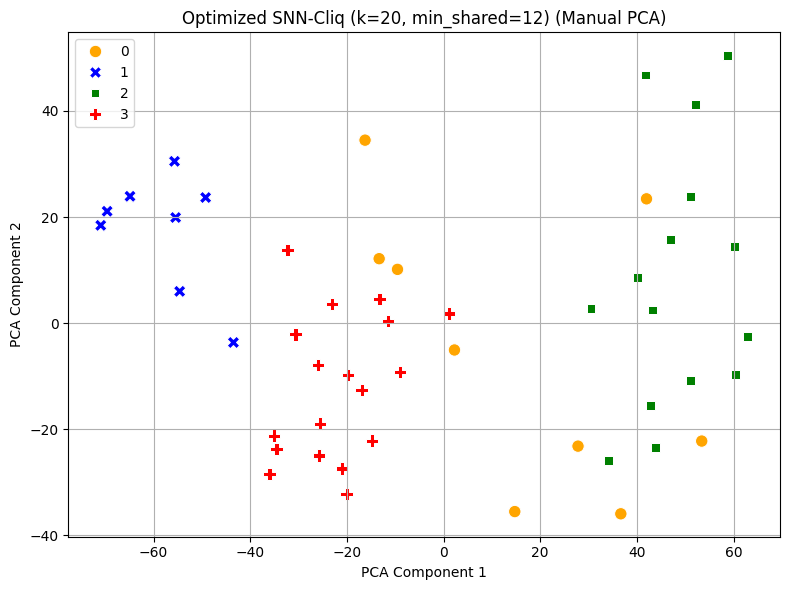

Running grid search for ALLAML dataset ...

Best Hyperparameters: k=60, min_shared_neighbors=6
Silhouette Score: 0.069
Purity Score:     0.540
Adjusted Rand Index (ARI): -0.014
Normalized Mutual Information (NMI): 0.000
Fowlkes-Mallows Index (FMI): 0.573


C:\Users\Himanshu Gaur\AppData\Local\Temp\ipykernel_15104\900277228.py:129: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=cluster_labels,


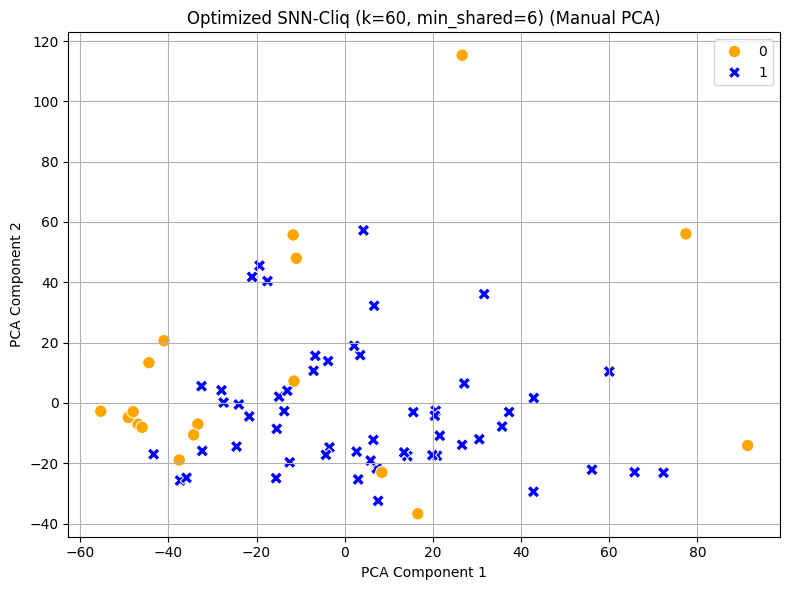

Grid search completed.


In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
from numpy.linalg import eigh
import networkx as nx
from sklearn.metrics.cluster import pair_confusion_matrix  

# === Load and preprocess the GLIOMA dataset (Dataset 1) ===
mat1 = scipy.io.loadmat("GLIOMA.mat")  #This is the dataset GLIOMA.mat 

data1 = mat1['X']
labels1 = mat1['Y'].squeeze()

scaler = StandardScaler()
data1_scaled = scaler.fit_transform(data1)

encoder = LabelEncoder()
labels1_encoded = encoder.fit_transform(labels1)

# === Load and preprocess the second dataset (ALLAML) ===
mat2 = scipy.io.loadmat("ALLAML.mat") ## This is the dataset ALLAML.mat

data2 = mat2['X']
labels2 = mat2['Y'].squeeze()

data2_scaled = scaler.fit_transform(data2)
labels2_encoded = encoder.fit_transform(labels2)

# === Manual PCA for dimensionality reduction ===
def custom_pca(data, n_components=2):
    mu = np.mean(data, axis=0)
    X = data - mu
    cov_matrix = np.cov(X, rowvar=False)
    eigvals, eigvecs = eigh(cov_matrix)
    sorted_idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, sorted_idx]
    return np.dot(X, eigvecs[:, :n_components])

# === Compute purity score based on pair confusion matrix ===
def purity_score(y_true, y_pred):
    contingency = pair_confusion_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)

# === Core functions for SNN-Cliq Clustering ===
def compute_knn(data, k):
    from sklearn.metrics.pairwise import euclidean_distances
    dist = euclidean_distances(data)
    np.fill_diagonal(dist, np.inf)
    neighbors = np.argsort(dist, axis=1)[:, :k]
    return neighbors

def build_snn_graph(data, k=7, min_shared=2):
    neighbors = compute_knn(data, k)
    G = nx.Graph()
    for i in range(len(data)):
        for j in neighbors[i]:
            shared = len(np.intersect1d(neighbors[i], neighbors[j]))
            if shared >= min_shared:
                G.add_edge(i, j, weight=shared)
    return G

# SNN-Cliq Clustering class
class SNNCliq:
    def __init__(self, data, k=7, min_shared_neighbors=2, n_clusters=4):
        self.data = data
        self.k = k
        self.min_shared = min_shared_neighbors
        self.n_clusters = n_clusters
        self.graph = build_snn_graph(data, k=self.k, min_shared=self.min_shared)
        self.clusters = []

    def fit(self):
        visited = set()
        for node in self.graph.nodes:
            if node in visited:
                continue
            clique = self._find_clique(node, visited)
            if clique:
                self.clusters.append(clique)
                visited.update(clique)

    def _find_clique(self, node, visited):
        clique = [node]
        neighbors = set(self.graph.neighbors(node)) - visited
        for n in neighbors:
            if all(self.graph.has_edge(n, c) and self.graph[n][c]['weight'] >= self.min_shared for c in clique):
                clique.append(n)
        return clique if len(clique) > 1 else []

    def get_labels(self, n):
        labels = [-1] * n
        for i, cluster in enumerate(self.clusters):
            for idx in cluster:
                labels[idx] = i

        if len(self.clusters) < self.n_clusters:
            return np.zeros(n, dtype=int)

        if len(self.clusters) > self.n_clusters:
            cluster_sizes = [len(cluster) for cluster in self.clusters]
            largest_clusters = np.argsort(cluster_sizes)[-self.n_clusters:]
            new_labels = np.zeros(n, dtype=int)
            for i, cluster in enumerate(self.clusters):
                if i in largest_clusters:
                    new_labels[np.array(cluster)] = largest_clusters.tolist().index(i)
            return new_labels
        return np.array(labels)

# === Clustering evaluation ===
def evaluate_clustering(data, true_labels, cluster_labels):
    if len(np.unique(cluster_labels)) < 2:
        return 0, 0, 0, 0, 0

    sil = silhouette_score(data, cluster_labels)
    pur = purity_score(true_labels, cluster_labels)
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    fmi = fowlkes_mallows_score(true_labels, cluster_labels)
    
    return sil, pur, ari, nmi, fmi

# === Visualization using PCA only ===
def visualize(data, cluster_labels, title="SNN-Cliq Clustering"):
    color_palette = ['orange', 'blue', 'green', 'red']
    pca_data = custom_pca(data, n_components=2)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=cluster_labels,
                    palette=color_palette, s=80, style=cluster_labels)
    plt.title(f"{title} (Manual PCA)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Perform hyperparameter tuning with grid search ===
def grid_search(k_values, min_shared_values, data, labels_encoded, n_clusters):
    best_silhouette = -1
    best_k = None
    best_min_shared = None
    best_labels = None
    best_metrics = None

    for k in k_values:
        for min_shared in min_shared_values:
            snn = SNNCliq(data, k=k, min_shared_neighbors=min_shared, n_clusters=n_clusters)
            snn.fit()
            labels_pred = snn.get_labels(len(data))

            sil, pur, ari, nmi, fmi = evaluate_clustering(data, labels_encoded, labels_pred)
            
            if sil > best_silhouette:
                best_silhouette = sil
                best_k = k
                best_min_shared = min_shared
                best_labels = labels_pred
                best_metrics = (sil, pur, ari, nmi, fmi)

    print(f"\nBest Hyperparameters: k={best_k}, min_shared_neighbors={best_min_shared}")
    print(f"Silhouette Score: {best_metrics[0]:.3f}")
    print(f"Purity Score:     {best_metrics[1]:.3f}")
    print(f"Adjusted Rand Index (ARI): {best_metrics[2]:.3f}")
    print(f"Normalized Mutual Information (NMI): {best_metrics[3]:.3f}")
    print(f"Fowlkes-Mallows Index (FMI): {best_metrics[4]:.3f}")
    
    visualize(data, best_labels, title=f"Optimized SNN-Cliq (k={best_k}, min_shared={best_min_shared})")

# === Define hyperparameter ranges ===
k_values = [10, 20, 30, 40, 50, 60, 70]
min_shared_values = [6, 12, 18, 24, 30, 36, 42, 48]

# === Run the grid search on both datasets ===
print("Running grid search for GLIOMA dataset ...")
grid_search(k_values, min_shared_values, data1_scaled, labels1_encoded, n_clusters=4)

print("Running grid search for ALLAML dataset ...")
grid_search(k_values, min_shared_values, data2_scaled, labels2_encoded, n_clusters=2)

print("Grid search completed.")
